In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import calendar as calendar
import datetime
sb.set()

In [2]:
df = pd.read_csv('carpark_availability_cleaned.csv')
holidays_df = pd.read_csv('sg_holidays.csv')
carpark_info = pd.read_csv('carpark_info_cleaned.csv')

In [3]:
df['update_datetime']= pd.to_datetime(df['update_datetime'])
df = df.drop(columns=['total_lots'])
df.head()

,carpark_number,update_datetime,lots_available,hour_delta,day,hour,carpark_index,holiday
0,J70,2018-01-01 00:00:00,0,0.0,0,0,0,1
1,J70,2018-01-01 01:00:00,0,1.0,0,1,0,0
2,J70,2018-01-01 02:00:00,0,2.0,0,2,0,0
3,J70,2018-01-01 03:00:00,0,3.0,0,3,0,0
4,J70,2018-01-01 04:00:00,0,4.0,0,4,0,0


In [4]:
carpark_arr = df.carpark_number.unique()

# Split Train/Test Evenly

In [5]:
tempDf = df.copy()
tempDf.insert(0, 'id', range(0, len(tempDf)))

trainDf = pd.DataFrame()
# Split Data based on individual carpark, day and hour
for carpark_num in range(len(carpark_arr)):
    print("Parsing " + carpark_arr[carpark_num])
    for days in range(0,7):
        for hours in range(0,24):
            trainDf = pd.concat([trainDf, tempDf[(tempDf['carpark_number'] == carpark_arr[carpark_num]) & (tempDf['day'] == days) & (tempDf['hour'] == hours)].sample(frac=0.8,random_state=500)]) # Train
print("Completed")

Parsing J70
Parsing J85M
Parsing J72
Parsing J69
Parsing JM31
Parsing J62M
Parsing J63
Parsing J83M
Parsing J67
Parsing JM2
Completed


In [6]:
trainDf.head(5)

,id,carpark_number,update_datetime,lots_available,hour_delta,day,hour,carpark_index,holiday
4200,4200,J70,2018-06-25,0,4200.0,0,0,0,0
32240,32240,J70,2021-09-06,0,32256.0,0,0,0,0
14448,14448,J70,2019-08-26,0,14448.0,0,0,0,0
33416,33416,J70,2021-10-25,0,33432.0,0,0,0,0
34921,34921,J70,2021-12-27,0,34944.0,0,0,0,0


In [7]:
testDf = tempDf[~tempDf['id'].isin(trainDf['id'])] #Test
testDf.head(5)

,id,carpark_number,update_datetime,lots_available,hour_delta,day,hour,carpark_index,holiday
199,199,J70,2018-01-09 07:00:00,17,199.0,1,7,0,0
336,336,J70,2018-01-15 00:00:00,0,336.0,0,0,0,0
337,337,J70,2018-01-15 01:00:00,0,337.0,0,1,0,0
338,338,J70,2018-01-15 02:00:00,0,338.0,0,2,0,0
339,339,J70,2018-01-15 03:00:00,0,339.0,0,3,0,0


In [8]:
trainDf = trainDf.drop(columns=['id'])
testDf = testDf.drop(columns=['id'])
trainDf = trainDf.reset_index(drop=True)
testDf = testDf.reset_index(drop=True)

In [9]:
print("Train Shape: " + str(trainDf.shape))
print("Test Shape: " + str(testDf.shape))

Train Shape: (280160, 8)
Test Shape: (70034, 8)


# Train Using Decision Tree Regressor Individual

In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score, cross_val_predict

In [58]:
dtreg_models = []

dtreg_predictions = {} # Dictionary for Decision Tree Models

dtreg_CV = pd.DataFrame(columns=["carpark","trainCV","testCV"])

for carpark in carpark_arr:
    dtreg = DecisionTreeRegressor(random_state=0, max_depth=4)
    # print("Training " + carpark)
    trainDf2 = trainDf[trainDf['carpark_number'] == carpark]
    testDf2 = testDf[testDf['carpark_number'] == carpark]

    trainX = trainDf2[['day','hour','hour_delta']]
    trainY = trainDf2['lots_available'].values

    testX = testDf2[['day','hour','hour_delta']]
    testY = testDf2['lots_available'].values

    model_dtreg = dtreg.fit(trainX,trainY)
    
    cv10_score = cross_val_score(model_dtreg, trainX, trainY, scoring="r2", cv=10)
    
    pred_score = cross_val_score(model_dtreg,  testX, testY, scoring="r2", cv=10)

    
    dtreg_append = {'carpark':carpark, 'trainCV': np.mean(cv10_score), 'testCV': np.mean(pred_score)}
    dtreg_CV = dtreg_CV.append(dtreg_append,ignore_index=True)
    
    #   Take Average Of Data For Graph Plotting
    testDf2 = testDf2.groupby(['day','hour'], as_index = False)['lots_available'].mean()

    testX = testDf2[['day','hour']]
    testY = testDf2['lots_available'].values
    
    predict_Y = cross_val_predict(model_dtreg, testX, testY)
    
    testDf2["predicted_lots"] = predict_Y.tolist()

    testDf2['day_hour'] = testDf2['day'].astype(str) + "-" + testDf2['hour'].astype(str)

    dtreg_predictions[carpark] = testDf2.copy()

    dtreg_models.append(model_dtreg)


with pd.option_context('display.max_rows', None,
                   'display.max_columns', None,
                   'display.width', 1000,
                   'display.precision', 3,
                   'display.colheader_justify', 'center'):
    print("Decision Tree:\nCross-validation 10-Folds Average")
    display(dtreg_CV)

Decision Tree:
Cross-validation 10-Folds Average


,carpark,trainCV,testCV
0,J70,0.316,0.509
1,J85M,0.740,0.344
2,J72,0.716,0.631
3,J69,0.709,0.499
4,JM31,0.476,-0.409
5,J62M,0.658,0.058
6,J63,0.400,0.602
7,J83M,0.920,0.623
8,J67,0.053,-0.058
9,JM2,0.731,-2.646


In [59]:
dtreg_models[0]

DecisionTreeRegressor(max_depth=4, random_state=0)

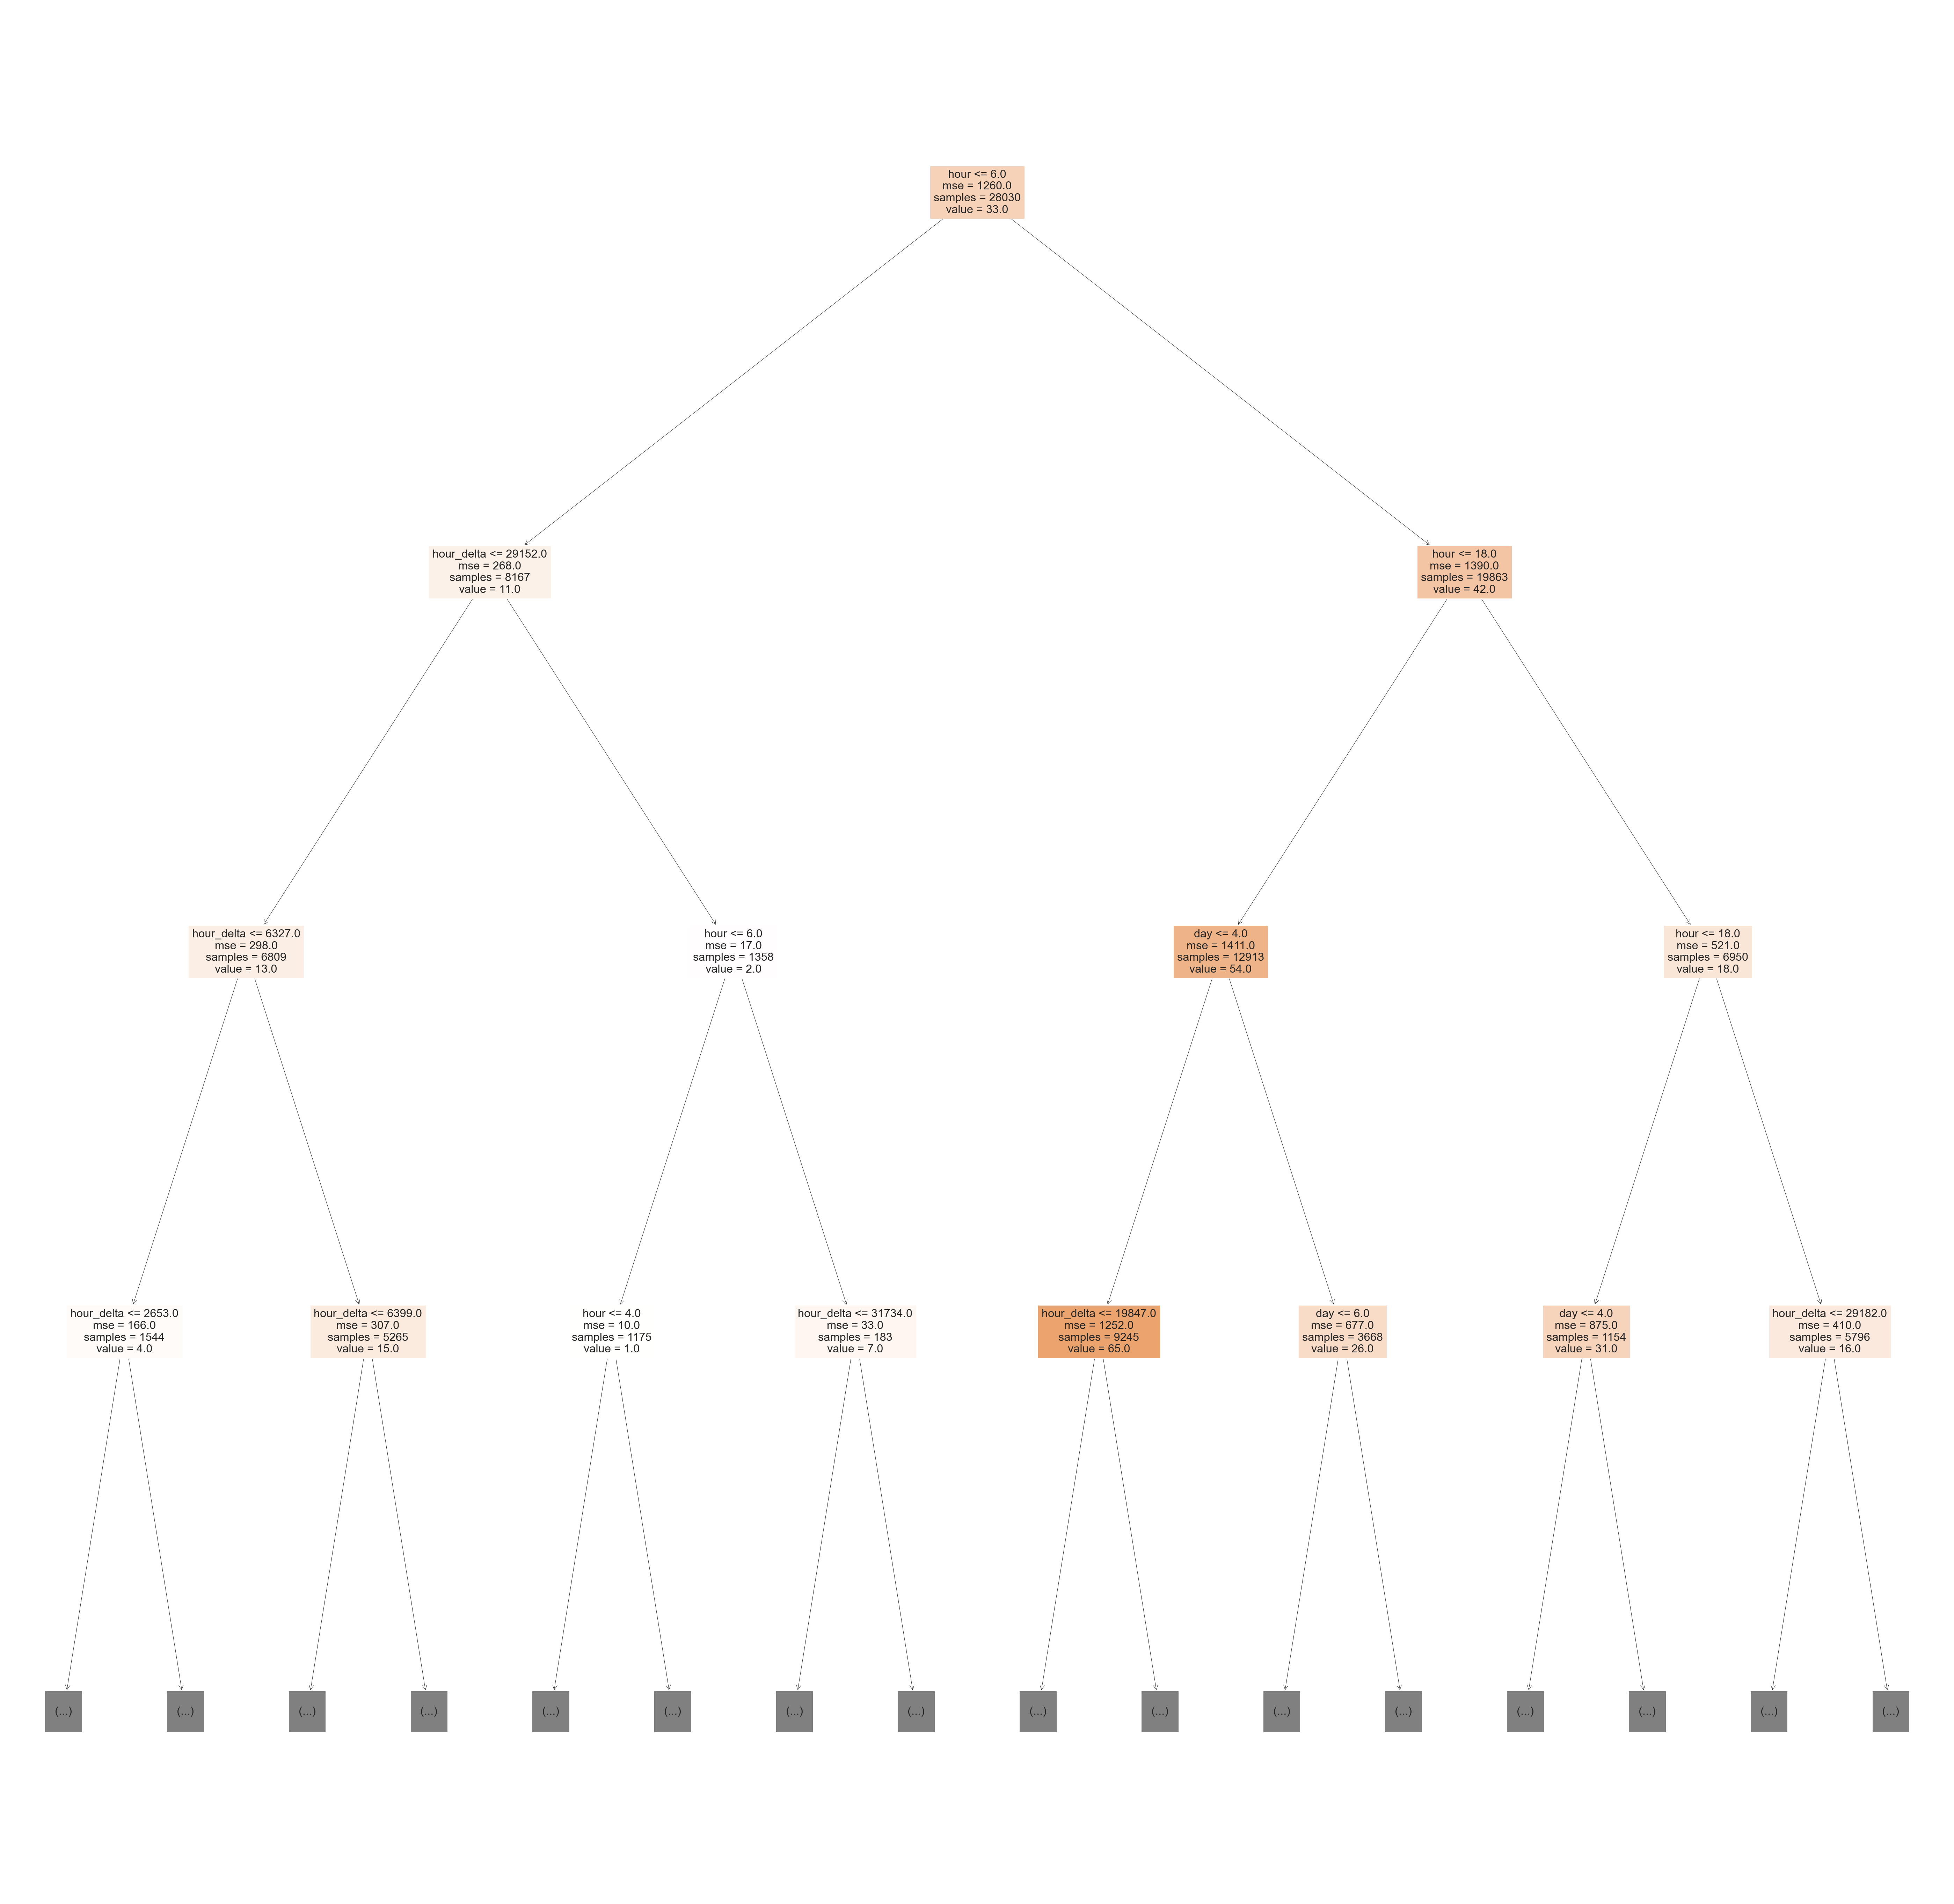

In [60]:
fig = plt.figure(figsize=(100,100))
_ = tree.plot_tree(dtreg_models[0], feature_names=["day","hour","hour_delta"], max_depth=3, precision=0,filled=True)

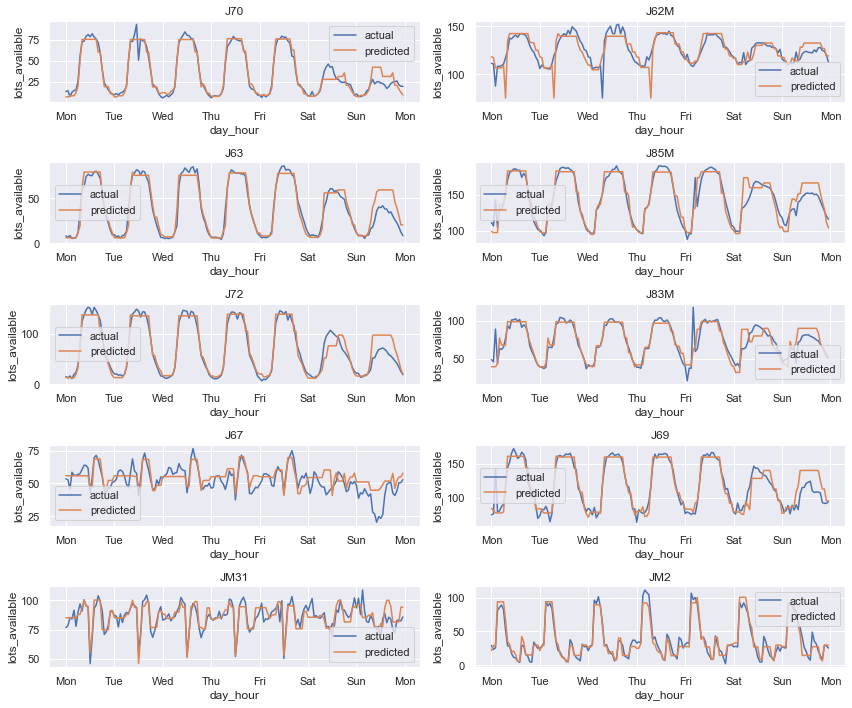

In [17]:
rows = int(len(carpark_arr)/2)
fig, axis = plt.subplots(nrows=rows, ncols=2)
fig.set_size_inches(12, 10)

fig.tight_layout()

i = 0
for carpark in dtreg_predictions.keys():
    dfPlot = dtreg_predictions[carpark]
    dfPlot["day_hour"] = "2022-08-" + (dfPlot['day']+1).astype(str) + " " + dfPlot["hour"].astype(str) + ":0:0"
    dfPlot["day_hour"] = pd.to_datetime(dfPlot["day_hour"], format= "%Y-%m-%d %H:%M:%S")
    date_format =  mdates.DateFormatter("%a")
    lp1 = sb.lineplot(x='day_hour',y='lots_available', legend='brief', label="actual",data=dfPlot, ax=axis[i%rows,i%2])
    lp2 = sb.lineplot(x='day_hour',y='predicted_lots', legend='brief', label="predicted",data=dfPlot, ax=axis[i%rows,i%2])
    lp1.set(title=str(carpark_arr[i]))
    lp1.xaxis.set_major_formatter(date_format)
    lp2.xaxis.set_major_formatter(date_format)
    
    i = i + 1
fig.tight_layout()

# Auto ARIMA

In [80]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [81]:
# Create Sections of Date for Forward Chaining Cross Validation
sortDf = df.copy()
sortDf = sortDf.sort_values(by=['update_datetime'])
sortDf = sortDf.reset_index(drop=True)
sortDf = sortDf.drop(columns=["day","hour","hour_delta","holiday","carpark_index"])


start = sortDf['update_datetime'].min()
end = sortDf['update_datetime'].max()

start_date = datetime.date(start.year, start.month, start.day)
daysInRange = (end-start)

split = daysInRange/5

split_end = []
split_start = []
split_start.append(start.strftime("%Y-%m-%d"))
for i in range(1,6):
    split_end.append((start_date + split * i).strftime("%Y-%m-%d"))
    split_start.append((datetime.datetime.strptime(split_end[i-1],"%Y-%m-%d")+timedelta(days=1)).strftime("%Y-%m-%d"))

split_start.pop(len(split_start)-1) 
print(split_start)
print(split_end)

['2018-01-01', '2018-10-21', '2019-08-09', '2020-05-27', '2021-03-15']
['2018-10-20', '2019-08-08', '2020-05-26', '2021-03-14', '2021-12-31']


In [82]:
forward_chain = []
for i in range(0, len(split_start)):
    start = split_start[i]
    end = split_end[i]
    forward_chain.append(sortDf[(sortDf['update_datetime'] >= start) & (sortDf['update_datetime'] <= end)].copy())

In [83]:
def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [84]:
test_dh = forward_chain[0].copy()
test_dh = test_dh[test_dh['carpark_number'] == carpark_arr[1]]
adfuller_test(test_dh['lots_available'])

ADF Test Statistic : -12.236631271105564
p-value : 1.0246177455325274e-22
#Lags Used : 34
Number of Observations : 6974
Data is stationary


In [89]:
# Forward Chaining on a Single Carpark
arima_df = forward_chain[0].copy()
arima_df = arima_df[arima_df['carpark_number'] == carpark_arr[1]]

arima_df = arima_df.drop(columns=["carpark_number"])
arima_df.sort_values(by=["update_datetime"],ignore_index=True)
arima_df = arima_df.set_index("update_datetime")
arima_df = arima_df.sort_index()

arima_model =  pm.auto_arima(arima_df, start_p=1, start_q=1,
                  max_p=3, max_q=3, # Maximum p and q
                  m=24,             # Frequency of series, hourly (24hrs a day)
                  d=None,          # No need difference, data already stationary
                  seasonal=True,
                  start_P=0, 
                  D=0, 
                  trace=True,
                  error_action='ignore',  
                  suppress_warnings=True, 
                  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=10.31 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=73184.998, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=13.65 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=7.49 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=93176.299, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=7.94 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=9.52 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=63890.157, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=7.50 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=20.59 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=63694.275, Time=0.32 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=23.92 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=5.64 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=24.47 se

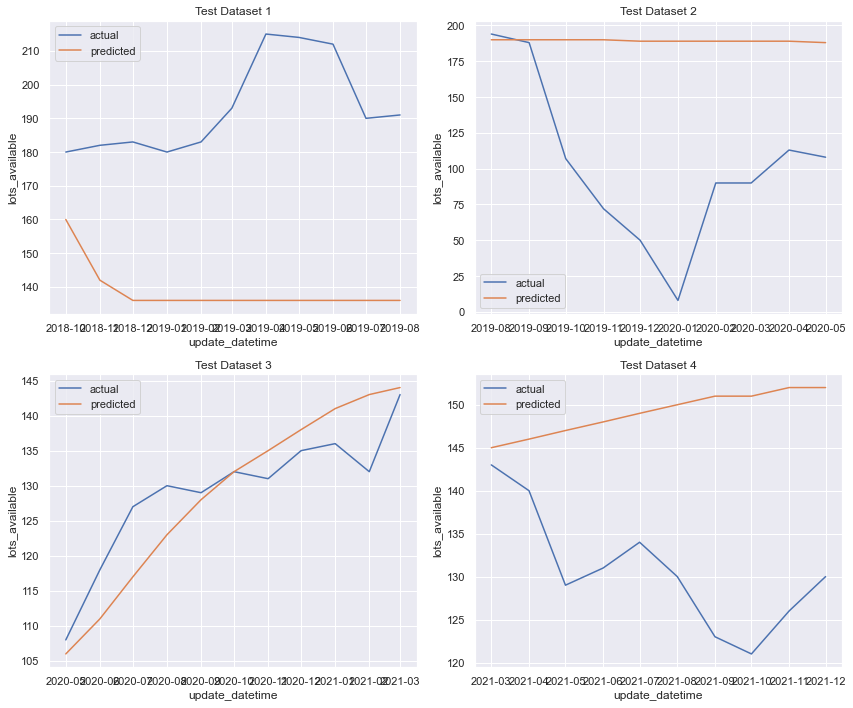

In [122]:
fig, axis = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)

fig.tight_layout()

for i in range(1,len(split_start)):
# for i in range(1,2):
    display_df = forward_chain[i].copy()
    display_df = display_df[display_df['carpark_number'] == carpark_arr[1]]
    arima_prediction = arima_model.predict(n_periods=display_df.shape[0])
    display_df["predicted_lots"] = arima_prediction.tolist()
    
    display_df = display_df.groupby(pd.PeriodIndex(display_df['update_datetime'], freq="M")).mean().astype(int)
    display_df["update_datetime"] = display_df.index
    display_df["update_datetime"] = pd.to_datetime(display_df['update_datetime'].astype(str), format='%Y-%m')
    display_df = display_df.reset_index(drop=True)

    date_format =  mdates.DateFormatter("%Y-%m")

    row = 0
    if (i >= 3):
        row = 1
    col = (i+1)%2

    lp1 = sb.lineplot(x='update_datetime' ,y='lots_available', legend='brief', label="actual",data=display_df, ax=axis[row,col])
    lp2 = sb.lineplot(x='update_datetime',y='predicted_lots', legend='brief', label="predicted",data=display_df, ax=axis[row,col])
    lp1.set(title=str("Test Dataset " + str(i)))
    lp1.xaxis.set_major_formatter(date_format)
    lp2.xaxis.set_major_formatter(date_format)
    
#     Update Model With next Train Data
    update_df = forward_chain[i].copy()
    update_df = update_df[update_df['carpark_number'] == carpark_arr[1]]

    update_df = update_df.drop(columns=["carpark_number"])
    update_df.sort_values(by=["update_datetime"],ignore_index=True)
    update_df = update_df.set_index("update_datetime")
    update_df = update_df.sort_index()
    
    arima_model.update(update_df)

fig.tight_layout()

# Testing Auto Arima with Single Dataset

In [64]:
test_df = forward_chain[0].copy()
test_df = test_df[test_df['carpark_number'] == carpark_arr[1]]
test_df
test_df = test_df.drop(columns=["carpark_number"])
test_df.sort_values(by=["update_datetime"],ignore_index=True)
test_df = test_df.set_index("update_datetime")
test_df = test_df.sort_index()
# test_df = test_df.resample("1D").mean()
# display(test_df)

arima_model =  pm.auto_arima(test_df, start_p=1, start_q=1,
                  max_p=2, max_q=2, # maximum p and q
                  m=24,              # frequency of series, weekly
                  d=None,           # No need difference, data already stationary
                  seasonal=True,   # Not calculating seasonality
                  start_P=0, 
                  D=0, 
                  trace=True,
                  error_action='ignore',  
                  suppress_warnings=True, 
                  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=10.24 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=73184.998, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=13.34 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=7.58 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=93176.299, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=7.33 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=10.77 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=63890.157, Time=1.45 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=7.54 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=21.18 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=63694.275, Time=0.42 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=24.29 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=5.70 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=25.18 s

,carpark_number,update_datetime,lots_available
7682,J85M,2018-02-02 00:00:00,89
7692,J85M,2018-02-02 01:00:00,88
7701,J85M,2018-02-02 02:00:00,86
7716,J85M,2018-02-02 03:00:00,87
7727,J85M,2018-02-02 04:00:00,216
...,...,...,...
8840,J85M,2018-02-06 20:00:00,131
8853,J85M,2018-02-06 21:00:00,121
8862,J85M,2018-02-06 22:00:00,104
8875,J85M,2018-02-06 23:00:00,97


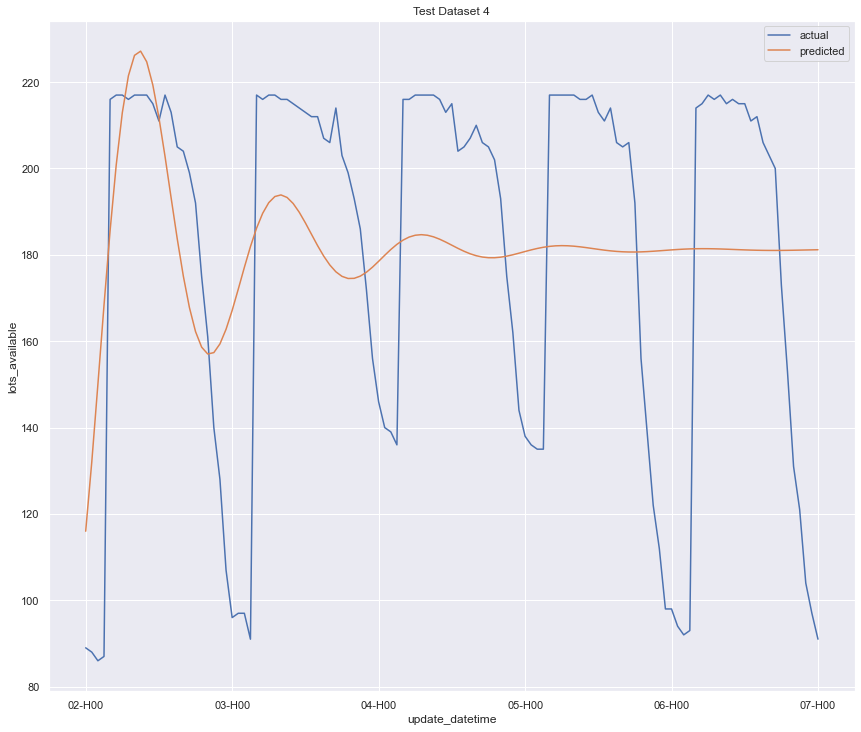

In [79]:
fig, axis = plt.subplots()
fig.set_size_inches(12, 10)

fig.tight_layout()

test_df2 = forward_chain[0].copy()
test_df2 = test_df2[(test_df2['update_datetime'] >= '2018-02-02') & (test_df2['update_datetime'] <= '2018-02-7')]
test_df2 = test_df2[test_df2['carpark_number'] == carpark_arr[1]]
display(test_df2)

display_df = test_df2.copy()
arima_prediction = arima_model.predict(n_periods=test_df2.shape[0])
display_df["predicted_lots"] = arima_prediction.tolist()

date_format =  mdates.DateFormatter("%d-H%H")

lp1 = sb.lineplot(x="update_datetime",y='lots_available', legend='brief', label="actual",data=display_df, ax=axis)
lp2 = sb.lineplot(x="update_datetime",y='predicted_lots', legend='brief', label="predicted",data=display_df, ax=axis)
lp1.set(title=str("Test Dataset " + str(i)))
lp1.xaxis.set_major_formatter(date_format)
lp2.xaxis.set_major_formatter(date_format)

ARIMA was not able to predict far into the future due to its predicting in "Steps", in this diagram, 
it was able to forecast 2 days before losing its accuracy (same as the q value).